### Import libraries

In [1]:
import torch
import numpy as np

from collections import deque
import matplotlib.pyplot as plt
from unityagents import UnityEnvironment
from dqn_agent import Agent

### Learning algorithm implementation

The following funtion implements the training algorithm. We also use it to evaluate the performance of our training agent by passing a value for the `training` parameter of `False`.

In [2]:
def dqn(agent, env, brain_name, n_episodes=2500, max_t=1000, eps_start=1.0,
        eps_end=0.01, eps_decay=0.998, train=True):
    """Deep Q-Learning.
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon,
                           for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode)
                           for decreasing epsilon
    """
    # list containing scores from each episode
    scores = []
    # set length of buffer to last 100 scores
    scores_window = deque(maxlen=100)
    eps = eps_start if train else 0.0
    for i_episode in range(1, n_episodes+1):
        # reset the environment
        env_info = env.reset(train_mode=train)[brain_name]
        # get the current state
        state = env_info.vector_observations[0]
        score = 0
        for _ in range(max_t):
            # select an action
            action = agent.act(state, eps)
            # send the action to the envirinment
            env_info = env.step(action)[brain_name]
            # get the next state
            next_state = env_info.vector_observations[0]
            reward = env_info.rewards[0]
            done = env_info.local_done[0]
            if train:
                agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break

        # save the most recent score
        scores_window.append(score)
        scores.append(score)
        # decrease epsilon
        eps = max(eps_end, eps_decay*eps)

        print('\rEpisode {}\tAverage Score: {:.2f}'.format(
            i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(
                i_episode, np.mean(scores_window)))
        if train and np.mean(scores_window) >= 13.0:
            print('\nEnv solved in {:d} episodes!\tAverage Score: {:.2f}'
                  .format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), 'checkpoint_dqn.pth')
            break
    return scores


### Runner funtion

The following funtion is used as the entry point to train or evaluate our agent. By simply passing a checkpoint file to the `chkp` parameter we set the `dqn` funtion in `eval` mode.

In [3]:
def runner(chkp=None):
    '''
    This function loads the environment and the agent. By default runs in
    training mode, but if a checkpoint file is passed it runs in eval mode.
    Params
    ======
        chkp (None|file): file containing a checkpoint saved during training.
    '''
    # instantiate Unity environment
    env = UnityEnvironment(file_name="Banana_Linux/Banana.x86_64")
    print('\n' + '-' * 7)
    # get first brain
    brain_name = env.brain_names[0]
    brain = env.brains[brain_name]
    env_info = env.reset(train_mode=True)[brain_name]
    action_size = brain.vector_action_space_size
    state = env_info.vector_observations[0]
    state_size = len(state)
    # instantiate the Agent using the state_size and action_size computed above
    agent = Agent(state_size=state_size, action_size=action_size, seed=0)

    # if a checkpoint is passed, go into eval mode
    if chkp:
        checkpoint = torch.load(chkp)
        # load the weights from a pretrained network
        agent.qnetwork_local.load_state_dict(checkpoint)
        agent.qnetwork_target.load_state_dict(checkpoint)

        # run eval
        scores = dqn(agent, env, brain_name, n_episodes=5, train=False)
    else:
        # run training
        scores = dqn(agent, env, brain_name, train=True)
        
    env.close()
    return scores

### Running the training phase

In [4]:
scores = runner()

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 



-------
Episode 100	Average Score: 0.16
Episode 200	Average Score: 1.68
Episode 300	Average Score: 3.49
Episode 400	Average Score: 4.96
Episode 500	Average Score: 6.44
Episode 600	Average Score: 8.32
Episode 700	Average Score: 9.95
Episode 800	Average Score: 11.30
Episode 900	Average Score: 12.51
Episode 1000	Average Score: 11.61
Episode 1065	Average Score: 13.07
Env solved in 965 episodes!	Average Score: 13.07


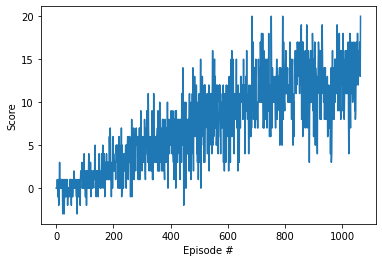

In [5]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Running the evaluation phase

In [ ]:
runner(chkp='checkpoint_dqn.pth')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 



-------
Episode 4	Average Score: 18.00